In [180]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [181]:
df = pd.read_csv("Dataset.csv")
df = pd.DataFrame(df)
df = df.drop(columns='Info')
df = df.drop(columns='Frame length')
df = df.drop(columns=['No.'])
# df['Time'] = pd.to_datetime(df['Time'], unit='s')
df = df.rename(columns= {'Time since previous frame' : 'Time since previous frame mean', 'Data length' : 'Data length mean'})

df.head(-1)

,Time,Time since previous frame mean,Source,Destination,Time to Live,Data length mean,Protocol
0,0.000000,0.000000,151.30.61.46,192.168.1.3,53,825,UDP
1,0.000323,0.000323,151.30.61.46,192.168.1.3,53,824,UDP
2,0.000703,0.000380,151.30.61.46,192.168.1.3,53,1014,UDP
3,0.001089,0.000386,151.30.61.46,192.168.1.3,53,1014,UDP
4,0.001091,0.000002,151.30.61.46,192.168.1.3,53,1014,UDP
...,...,...,...,...,...,...,...
656262,959.833570,0.000003,151.30.61.46,192.168.1.3,53,809,UDP
656263,959.836640,0.003070,151.30.61.46,192.168.1.3,53,808,UDP
656264,959.836642,0.000002,151.30.61.46,192.168.1.3,53,1155,UDP
656265,959.836642,0.000000,151.30.61.46,192.168.1.3,53,1155,UDP


In order to create a useful dataset to fit the models, we have to create samples by windowing the raw dataset with window of T seconds.
While aggregating every T seconds, we compute some useful features.

In [182]:
dst_address = "151.30.61.46"
time_window = "0.5S"

In [183]:
df['Data length std'] = df['Data length mean']
df['Data length median'] = df['Data length mean']
df['Time since previous frame std'] = df['Time since previous frame mean']
df['Time since previous frame median'] = df['Time since previous frame mean']


df_complete = df.groupby(pd.cut(df['Time'], np.arange(0, round(df.at[df.index[-1], 'Time']), 0.5))).agg(
    {'Time to Live' : np.mean, 'Time since previous frame mean' : np.mean, 'Time since previous frame std' : 'std', 'Time since previous frame median' : np.median,
     'Data length mean' : np.mean, 'Data length std' : 'std', 'Data length median': np.median})

'''
df_complete = df.resample(time_window, on='Time', kind='timestamp').agg(
    {'Time to Live' : np.mean, 'Time since previous frame mean' : np.mean, 'Time since previous frame std' : 'std', 'Time since previous frame median' : np.median,
     'Data length mean' : np.mean, 'Data length std' : 'std', 'Data length median': np.median})
'''

"\ndf_complete = df.resample(time_window, on='Time', kind='timestamp').agg(\n    {'Time to Live' : np.mean, 'Time since previous frame mean' : np.mean, 'Time since previous frame std' : 'std', 'Time since previous frame median' : np.median,\n     'Data length mean' : np.mean, 'Data length std' : 'std', 'Data length median': np.median})\n"

Since we want to compute the rate of inbound and outbound packets, we retrieve two sub-datasets to compute them.
Once computed, the columns are added to the original dataset.

In [184]:
df_complete

,Time to Live,Time since previous frame mean,Time since previous frame std,Time since previous frame median,Data length mean,Data length std,Data length median
Time,,,,,,,
"(0.0, 0.5]",58.251989,0.001302,0.003179,0.000002,877.575597,324.184903,981.0
"(0.5, 1.0]",58.558824,0.001325,0.003195,0.000002,856.040107,324.444109,962.5
"(1.0, 1.5]",58.614925,0.001436,0.003274,0.000002,829.504478,335.973702,924.0
"(1.5, 2.0]",58.530055,0.001384,0.003366,0.000002,839.967213,331.801845,931.0
"(2.0, 2.5]",58.440860,0.001339,0.003419,0.000002,840.841398,328.435750,975.5
...,...,...,...,...,...,...,...
"(957.0, 957.5]",58.484594,0.001400,0.003414,0.000002,815.126050,319.810624,915.0
"(957.5, 958.0]",58.575342,0.001322,0.003420,0.000002,788.991781,324.468970,918.0
"(958.0, 958.5]",58.660819,0.001443,0.003731,0.000002,774.435673,332.119878,892.0


In [185]:
df_inbound = df.loc[df['Source'] == dst_address]
df_outbound = df.loc[df['Destination'] == dst_address]

df_inbound = df_inbound.drop(columns=['Destination'])
df_outbound = df_outbound.drop(columns=['Source'])

In [186]:
df_inbound = df_inbound.groupby(pd.cut(df_inbound['Time'], np.arange(0, round(df_inbound.at[df_inbound.index[-1], 'Time']), 0.5))).agg(
    {'Source' : 'count'})

df_inbound = df_inbound.rename(columns={'Source' : 'Inbound Count'})


df_outbound = df_outbound.groupby(pd.cut(df_outbound['Time'], np.arange(0, round(df_outbound.at[df_outbound.index[-1], 'Time']), 0.5))).agg(
    {'Destination' : 'count'})

df_outbound = df_outbound.rename(columns={'Destination' : 'Outbound Count'})

In [187]:
inbound_count = df_inbound["Inbound Count"]
outbound_count = df_outbound["Outbound Count"]

df_complete = df_complete.join(inbound_count)
df_complete = df_complete.join(outbound_count)

df_complete["Total Count"] = df_complete["Inbound Count"].astype(int) + df_complete["Outbound Count"].astype(int)

df_complete.reset_index(inplace=True)

# Aggiunto nuova colonna time interval nella prima posizione
# Prendo la parte destra dell'intervallo della colonna 'Time' e setto 'Time Interval'
# Ho provato a mettere come stringa il time per lasciarlo pulito, ma non sono riuscito, non so se si possa

'''
df_complete.insert(0, 'Time Interval', pd.Series)

for i in range(df_complete['Time'].size):
    df_complete['Time Interval'][i] = df_complete['Time'].values[i].right

df_complete = df_complete.drop(columns='Time')
'''

"\ndf_complete.insert(0, 'Time Interval', pd.Series)\n\nfor i in range(df_complete['Time'].size):\n    df_complete['Time Interval'][i] = df_complete['Time'].values[i].right\n\ndf_complete = df_complete.drop(columns='Time')\n"

In [188]:
df_complete.head()

,Time,Time to Live,Time since previous frame mean,Time since previous frame std,Time since previous frame median,Data length mean,Data length std,Data length median,Inbound Count,Outbound Count,Total Count
0,"(0.0, 0.5]",58.251989,0.001302,0.003179,0.000002,877.575597,324.184903,981.0,197,180,377
1,"(0.5, 1.0]",58.558824,0.001325,0.003195,0.000002,856.040107,324.444109,962.5,185,189,374
2,"(1.0, 1.5]",58.614925,0.001436,0.003274,0.000002,829.504478,335.973702,924.0,164,171,335
3,"(1.5, 2.0]",58.530055,0.001384,0.003366,0.000002,839.967213,331.801845,931.0,182,184,366
4,"(2.0, 2.5]",58.440860,0.001339,0.003419,0.000002,840.841398,328.435750,975.5,188,184,372


In [189]:
labels = pd.read_csv("Labels.csv")
labels = pd.DataFrame(labels)

labels.head()

,label
0,1
1,1
2,1
3,1
4,1


In [190]:
df_complete = df_complete.join(labels)
df_complete = df_complete.dropna()
df_complete['label'] = df_complete['label'].astype(int)

df_complete

,Time,Time to Live,Time since previous frame mean,Time since previous frame std,Time since previous frame median,Data length mean,Data length std,Data length median,Inbound Count,Outbound Count,Total Count,label
0,"(0.0, 0.5]",58.251989,0.001302,0.003179,0.000002,877.575597,324.184903,981.0,197,180,377,1
1,"(0.5, 1.0]",58.558824,0.001325,0.003195,0.000002,856.040107,324.444109,962.5,185,189,374,1
2,"(1.0, 1.5]",58.614925,0.001436,0.003274,0.000002,829.504478,335.973702,924.0,164,171,335,1
3,"(1.5, 2.0]",58.530055,0.001384,0.003366,0.000002,839.967213,331.801845,931.0,182,184,366,1
4,"(2.0, 2.5]",58.440860,0.001339,0.003419,0.000002,840.841398,328.435750,975.5,188,184,372,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1914,"(957.0, 957.5]",58.484594,0.001400,0.003414,0.000002,815.126050,319.810624,915.0,179,178,357,0
1915,"(957.5, 958.0]",58.575342,0.001322,0.003420,0.000002,788.991781,324.468970,918.0,180,185,365,0
1916,"(958.0, 958.5]",58.660819,0.001443,0.003731,0.000002,774.435673,332.119878,892.0,166,176,342,0
1917,"(958.5, 959.0]",58.860119,0.001420,0.003426,0.000002,773.125000,336.355829,857.5,157,179,336,0


In [191]:
df_complete = df_complete.drop(columns=['Time'])
df_complete

,Time to Live,Time since previous frame mean,Time since previous frame std,Time since previous frame median,Data length mean,Data length std,Data length median,Inbound Count,Outbound Count,Total Count,label
0,58.251989,0.001302,0.003179,0.000002,877.575597,324.184903,981.0,197,180,377,1
1,58.558824,0.001325,0.003195,0.000002,856.040107,324.444109,962.5,185,189,374,1
2,58.614925,0.001436,0.003274,0.000002,829.504478,335.973702,924.0,164,171,335,1
3,58.530055,0.001384,0.003366,0.000002,839.967213,331.801845,931.0,182,184,366,1
4,58.440860,0.001339,0.003419,0.000002,840.841398,328.435750,975.5,188,184,372,1
...,...,...,...,...,...,...,...,...,...,...,...
1914,58.484594,0.001400,0.003414,0.000002,815.126050,319.810624,915.0,179,178,357,0
1915,58.575342,0.001322,0.003420,0.000002,788.991781,324.468970,918.0,180,185,365,0
1916,58.660819,0.001443,0.003731,0.000002,774.435673,332.119878,892.0,166,176,342,0
1917,58.860119,0.001420,0.003426,0.000002,773.125000,336.355829,857.5,157,179,336,0


In [192]:
df_complete = df_complete.drop(df_complete.tail(800).index)
df_complete

,Time to Live,Time since previous frame mean,Time since previous frame std,Time since previous frame median,Data length mean,Data length std,Data length median,Inbound Count,Outbound Count,Total Count,label
0,58.251989,0.001302,0.003179,0.000002,877.575597,324.184903,981.0,197,180,377,1
1,58.558824,0.001325,0.003195,0.000002,856.040107,324.444109,962.5,185,189,374,1
2,58.614925,0.001436,0.003274,0.000002,829.504478,335.973702,924.0,164,171,335,1
3,58.530055,0.001384,0.003366,0.000002,839.967213,331.801845,931.0,182,184,366,1
4,58.440860,0.001339,0.003419,0.000002,840.841398,328.435750,975.5,188,184,372,1
...,...,...,...,...,...,...,...,...,...,...,...
1114,58.063492,0.001517,0.003880,0.000001,857.117460,343.189010,971.0,170,145,315,0
1115,58.264026,0.001629,0.003520,0.000002,834.320132,354.981195,955.0,158,145,303,0
1116,57.888889,0.001585,0.003555,0.000002,834.342857,351.683852,973.0,175,140,315,0
1117,58.287097,0.001602,0.003546,0.000002,841.190323,349.257584,964.0,161,149,310,0


In [193]:
X = df_complete.loc[:, df_complete.columns != 'label']
Y = df_complete['label']

standardizer = preprocessing.StandardScaler()
X = standardizer.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [194]:
y_true = Y_test
y_true = pd.DataFrame(y_true)

label_names = ['Person' , 'Background']

In [195]:
model1 = KNeighborsClassifier()
model1.fit(X_train,Y_train)

KNeighborsClassifier()

In [196]:
y_pred_class1 = model1.predict(X_test)
y_pred_class1 = pd.DataFrame(y_pred_class1)

In [197]:
metrics.accuracy_score(y_true, y_pred_class1)

0.6964285714285714

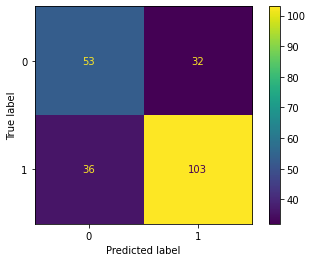

In [198]:
conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred_class1, labels=model1.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model1.classes_)

disp.plot()

plt.show()

In [199]:
print(classification_report(y_true=y_true, y_pred=y_pred_class1, target_names=label_names))

              precision    recall  f1-score   support

      Person       0.60      0.62      0.61        85
  Background       0.76      0.74      0.75       139

    accuracy                           0.70       224
   macro avg       0.68      0.68      0.68       224
weighted avg       0.70      0.70      0.70       224



In [200]:
# sns.set_style("whitegrid")
# sns.pairplot(df_complete, hue="label", height=3)
# plt.show()

In [201]:
model2 = RandomForestClassifier()
y_pred_class2 = model2.fit(X_train, Y_train)

In [202]:
y_pred_class2 = model2.predict(X_test)
y_pred_class2 = pd.DataFrame(y_pred_class2)

In [203]:
metrics.accuracy_score(y_true, y_pred_class2)

0.71875

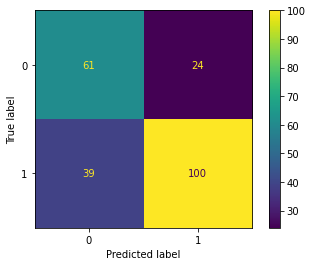

In [204]:
conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred_class2, labels=model2.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model2.classes_)

disp.plot()

plt.show()

In [205]:
print(classification_report(y_true=y_true, y_pred=y_pred_class2, target_names=label_names))

              precision    recall  f1-score   support

      Person       0.61      0.72      0.66        85
  Background       0.81      0.72      0.76       139

    accuracy                           0.72       224
   macro avg       0.71      0.72      0.71       224
weighted avg       0.73      0.72      0.72       224



In [206]:
y_true.to_csv("expected_labels.csv", index=False)
y_pred_class1.to_csv("pred_labels_class1.csv", index=False)
y_pred_class2.to_csv("pred_labels_class2.csv", index=False)